# Tarea 4 - RLM y SVM
## Regresión lineal múltiple y Support Vector Machines

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Aprendizaje Automático

---

## Carlos E. Hdz Rincón - A01181616

# Carga de datos
Esta tarea está basada en una base de datos de precios de casas de California que se
encuentran en dos archivos: el un conjunto de datos de entrenamiento (17,000) y el conjunto
de prueba (3,000):

https://www.kaggle.com/vikramtiwari/california-housing-dataset-ml-crash-course

Descarga ambos archivos: `california_housing_train.csv`, `california_housing_test.csv`


In [ ]:
%matplotlib inline

import numpy as np    # biblioteca para el manejo de vectores y matrices en python.
import pandas as pd   # biblioteca para el manejo de datos y tablas.
import matplotlib.pyplot as plt   # biblioteca para visualización de datos.

import statsmodels.api as sm      # biblioteca para pruebas estadísticas.
from statsmodels.tools.eval_measures import mse

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Connect to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
data_root_location = "/content/drive/My Drive/Datasets/CaliforniaHousingDataset/"
train_filename = "california_housing_train.csv"
test_filename = "california_housing_test.csv"

datatrain = pd.read_csv(f"{data_root_location}{train_filename}",
                        header=0)
print(datatrain.head())
print(f"Train: {datatrain.shape}")

datatest = pd.read_csv(f"{data_root_location}{test_filename}",
                       header=0)
print(datatest.head())
print(f"Test: {datatest.shape}")

# Extract the features and labels for better manipulation
def separate_variables_labels(data: pd.DataFrame, ind_var_name: str) -> tuple:
    return data.drop(ind_var_name, axis=1), data[ind_var_name]

X_train, y_train = separate_variables_labels(datatrain, "median_house_value")
X_test, y_test = separate_variables_labels(datatest, "median_house_value")

   longitude  latitude  ...  median_income  median_house_value
0    -114.31     34.19  ...         1.4936             66900.0
1    -114.47     34.40  ...         1.8200             80100.0
2    -114.56     33.69  ...         1.6509             85700.0
3    -114.57     33.64  ...         3.1917             73400.0
4    -114.57     33.57  ...         1.9250             65500.0

[5 rows x 9 columns]
Train: (17000, 9)
   longitude  latitude  ...  median_income  median_house_value
0    -122.05     37.37  ...         6.6085            344700.0
1    -118.30     34.26  ...         3.5990            176500.0
2    -117.81     33.78  ...         5.7934            270500.0
3    -118.36     33.82  ...         6.1359            330000.0
4    -119.67     36.33  ...         2.9375             81700.0

[5 rows x 9 columns]
Test: (3000, 9)


# 1. 
Utilizando los datos de entrenamiento sin hacerles algún preprocesamiento: 

## a)
Obtener el modelo de regresión lineal múltiple (RLM).

## b)

Obtener los coeficientes del modelo y la significancia de cada uno de dichos coeficientes.

In [ ]:
def train_regression_model(X: pd.core.frame.DataFrame, y: pd.core.frame.DataFrame):
    xones = sm.add_constant(X)  # Agregamos una columna de 1s

    model = sm.OLS(y, xones).fit()
    print(model.summary())

    return model

def predict(model, X: pd.core.frame.DataFrame):
    xones = sm.add_constant(X)   # Add a column of 1s
    y_predicted = model.predict(xones)

    # We'll get a series, but for the dependent variables it's easier to use
    #  Numpy representations
    return y_predicted.to_numpy()

basic_model = train_regression_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     3798.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:39:42   Log-Likelihood:            -2.1365e+05
No. Observations:               17000   AIC:                         4.273e+05
Df Residuals:                   16991   BIC:                         4.274e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.621e+06   6.92

## c)
Utilizando ahora el conjunto de datos de prueba:

### i.
Obtener la media de la suma de los cuadrados de los errores (MSSE) y el coeficiente de correlación ajustado ($R^2_{adj}$). 

In [ ]:
def sse(y_real: np.ndarray, y_predicted: np.ndarray):
    y_predicted = y_predicted.reshape(y_real.shape)
    return np.sum(np.square(y_real - y_predicted))

def adj_r_squared(y_real, y_predicted, n_samples:int, k_ind_var:int):

    # Let's make sure that y_predicted is in the same shape as y_real
    y_predicted = y_predicted.reshape(y_real.shape)

    # Squared sum of errors
    model_sse = sse(y_real, y_predicted)

    y_mean = np.mean(y_real)

    # Squared sum of regression + sse = syy
    syy = np.sum(np.square(y_real - y_mean))

    r_squared = 1 - (model_sse/syy)

    # Number of samples, independent variables (Columns in X)
    adj_r_squared = 1 - (((n_samples - 1)/(n_samples-k_ind_var-1)) * (1-r_squared))

    return adj_r_squared

y_predicted_test_basic_model = predict(basic_model, X_test)

print(f"MSE para dataset de prueba: {mse(y_test, y_predicted_test_basic_model)}")
print(f"Adj. R^2: {adj_r_squared(y_test, y_predicted_test_basic_model, n_samples = X_test.shape[0], k_ind_var=X_test.shape[1])}")



MSE para dataset de prueba: 4867205486.928856
Adj. R^2: 0.6184880634322204


### ii.
Usando el vector de predicciones del modelo para los precios medios de las casas y la variable *median\_house\_value*: 

1. Obtener la gráfica de dispersión entre dichas variables. Teóricamente ¿qué gráfica se esperaría obtener?
1. Obtener el coeficiente de correlación de Pearson entre ambas variables.
1. Obtener el coseno del ángulo entre ambas variables. NOTA: Tanto el coeficiente de correlación de Pearson como el coseno del ángulo se utilizan usualmente como métricas para medir el desempeño en los modelos de regresión lineal.

---
Se esperaría tener una línea recta en diagonal ya que en una relación perfecta la predicción se mantendría en el mismo lugar que el la lectura real. Es decir, una identidad con una 45˚ donde las variables tendrían una correlación de 1.

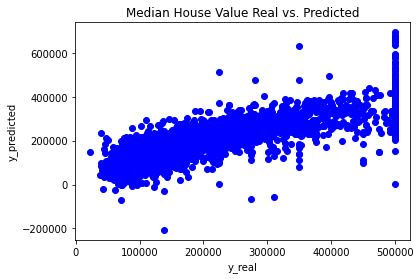

In [ ]:
def plot_median_house_value(y_real: np.ndarray, y_predicted: np.ndarray):

    # True Values vs predicted
    plt.scatter(y_real, y_predicted, color="b")

    plt.xlabel("y_real")
    plt.ylabel("y_predicted")
    plt.title("Median House Value Real vs. Predicted")

    plt.show()

plot_median_house_value(y_test, y_predicted_test_basic_model)

In [ ]:
def my_pearson(x: np.ndarray, y: np.ndarray):
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum(np.multiply((x - x_mean),(y - y_mean)))
    denominator = np.multiply(np.sqrt(np.sum(np.square(x - x_mean))),
                              np.sqrt(np.sum(np.square(y - y_mean))))

    res = numerator / denominator
    return res

def my_cosine_similarity(x: np.ndarray, y: np.ndarray):
    numerator = np.sum(np.multiply(x, y))
    denominator = np.multiply(np.sqrt(np.sum(np.square(x))),
                              np.sqrt(np.sum(np.square(y))))
    res = numerator/denominator
    return res

print(f"Pearson y_real vs y_predicted: {my_pearson(y_test, y_predicted_test_basic_model)}")
print(f"Cosine similarity y_real vs y_predicted: {my_cosine_similarity(y_test, y_predicted_test_basic_model)}")

Pearson y_real vs y_predicted: 0.7873228497213777
Cosine similarity y_real vs y_predicted: 0.9548661033305477


## d)
Reporta tus conclusiones. Este resultado se tomará como el modelo base para ser comparado con el resto de los ejercicios.

---

Con un valor $R^2_{adj} = 0.641$ para entrenamiento y un $R^2_{adj} = 0.619$ nos indica que el usar todas las variables independientes no ayudan a explicar muy bien la variable dependiente, a pesar que el valor P para todas las variables es 0.

Más aún, con un MSE para dataset de prueba de 4867205486.928856, podemos ver que el modelo tiene un error demasiado grande en sus predicciones para el dataset de prueba, lo que puede decirnos que, debido al ruido que algunas variables estén introduciendo, el error es muy grande.

La gráfica de dispersión entre las predicciones y los valores reales representan una tendencia a una diagonal positiva, se observa también la presencia de mucha varianza, varios outliers y muchos fallos conforme el valor de la casa se hace más grande. Este último punto puede ser la razón por la cual el valor de los errores se dispara demasiado.

El coeficiente de Pearson de 0.7873228497213777 nos dice lo que la gráfica de dispersión nos muestra: una correlación que tiende a ser positiva (cercana a 1) y la similaridad de coseno de 0.9548661033305477 nos confirma que el vector de predicciones y de valores reales tiende a apuntar hacia la misma dirección.

En resumen, este modelo se nota un poco "sucio", limpiar un poco los datos de entrada, escalación y/o normalización puede que nos permita incrementar el valor de $R^2_{adj}$, Pearson y Coseno.

# 2.

En los siguientes incisos deberás usar solamente el archivo con los datos de entrenamiento. Es decir, en este ejercicio no debes usar todavía los datos de prueba del archivo `california_housing_test.csv`.

## a)

Realiza un análisis descriptivo de los datos: mínimo, máximo, mediana, media,
primer y tercer cuartil, si existen datos perdidos, etc.

In [ ]:
datatrain.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
datatrain.median()

longitude               -118.4900
latitude                  34.2500
housing_median_age        29.0000
total_rooms             2127.0000
total_bedrooms           434.0000
population              1167.0000
households               409.0000
median_income              3.5446
median_house_value    180400.0000
dtype: float64

In [ ]:
datatrain.mode(axis=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-118.31,34.06,52.0,1582.0,280.0,891.0,306.0,3.125,500001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,386.0,NaN,NaN


In [ ]:
datatrain.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

No hay datos perdidos

## b)
Obtener los diagramas de caja e histogramas de todas las variables. Reporta tus
conclusiones a partir de dichos gráficos.


longitude                AxesSubplot(0.125,0.657941;0.227941x0.222059)
latitude              AxesSubplot(0.398529,0.657941;0.227941x0.222059)
housing_median_age    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
total_rooms              AxesSubplot(0.125,0.391471;0.227941x0.222059)
total_bedrooms        AxesSubplot(0.398529,0.391471;0.227941x0.222059)
population            AxesSubplot(0.672059,0.391471;0.227941x0.222059)
households                  AxesSubplot(0.125,0.125;0.227941x0.222059)
median_income            AxesSubplot(0.398529,0.125;0.227941x0.222059)
median_house_value       AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

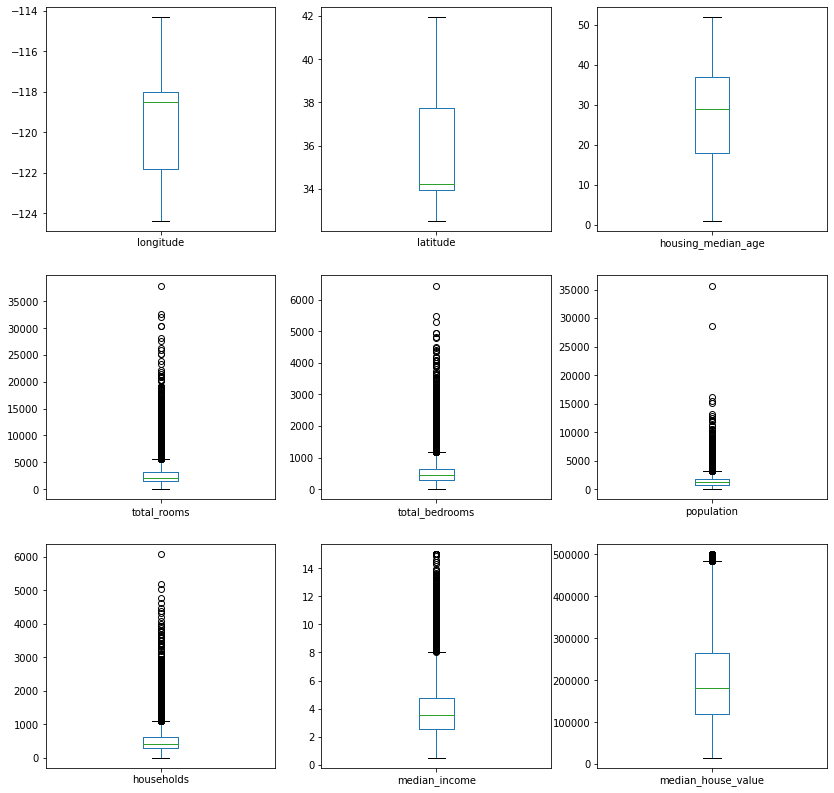

In [ ]:
datatrain.plot.box(subplots=True, layout=(3,3), figsize=(14,14))

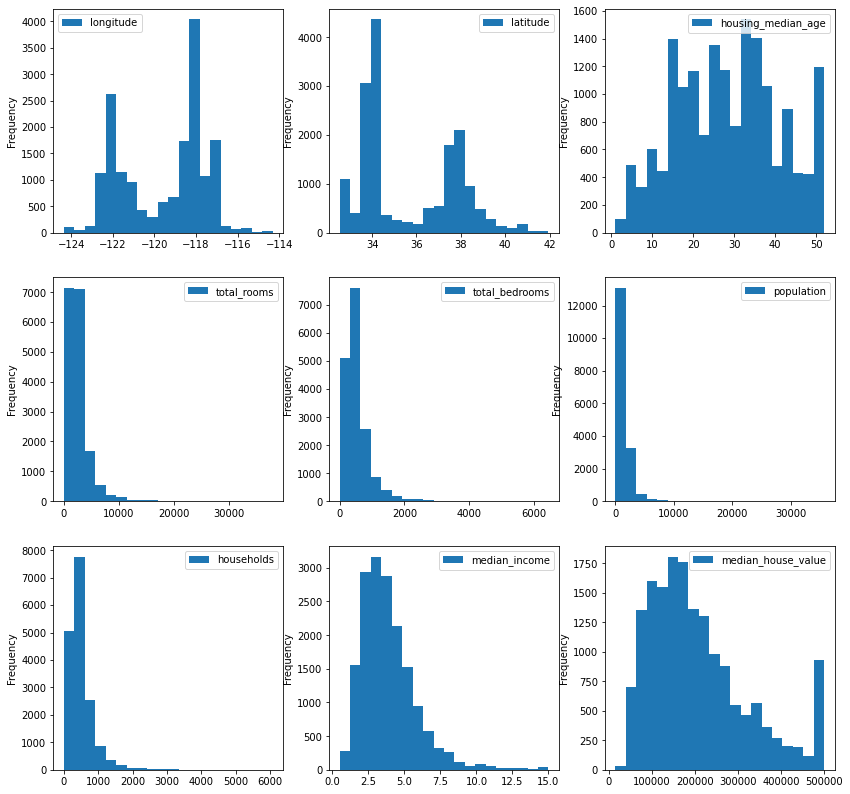

In [ ]:
def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):

    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)

plot_histogram(datatrain,3,3)

---
### Conclusiones

El dataset de entrenamiento no posee ningún valor faltante en ninguna de sus columnas, por lo que no se necesitará de ninguna estrategia de llenado para las mismas.

1. longitude
    * Los valores de la longitud no varían demasiado, lo cual puede explicarse a que es un dataset sobre una ubicación geográfica en específico (California).
    * Por lo tanto, tampoco se observan outliers en el boxplot.
    * La distribución de los valores presenta dos picos importantes que pueden deberse a grandes centros de población, como grandes ciudades.
1. latitude
    * El análisis de latitud es similar a las conclusiones que se alcanzaron para la longitud.
1. housing_median_age,
    * La distribución de valores no varía mucho, pero se pueden observar datos para casas muy nuevas y de hasta 52 años.
    * El box plot no muestra outliers en esta columna, por lo que todos los valores se encuentran entre 1 y 5 con un promedio de 28.58.
    * El histograma presenta una distribución que tiene al promedio, justo como lo presenta el boxplot.
1. total_rooms
    * La varianza para esta columna es considerablemente mayor que las últimas 3.
    * A pesar de que la media es de 2643.66, el boxplot muestra muchos outliers.
    * El histograma muestra un sesgo a la derecha.
1. total_bedrooms
    * Los datos muestran una varianza menor a total_rooms, pero aún significativa.
    * El boxplot muestra muchos outliers en el dataset.
    * El histograma muestra un sesgo a la derecha en los tados.
1. population
    * El dataset muestra una varianza significativa
    * El boxplot muestra muchos outliers.
    * Este dataset también presenta un sesgo a la derecha
1. households
    * La varianza es menor que en las anteriores columnas.
    * El boxplot muestra la presencia de muchos outliers
    * El histograma muestra un sesgo a la derecha importante
1. median_income
    * La varianza es mínima
    * El boxplot muestra muchos outliers a pesar de que la columna posee un rango reducido.
    * El histograma muestra un sesgo a la derecha, pero no tan pronunciado como las columnas anteriores.
1. median_house_value
    * El rango de valores es muy ampli en comparación con las otras columnas y posee una varianza muy grande.
    * Si bien el boxplot muestra que la mayoría de los valores se mantiene dentro del rango esperado, existe la presencia de un reducido número de outliers.
    * El histograma presenta un sesgo ligero a la derecha



## c)
A partir de los gráficos anteriores, deberás proponer algún ajuste en relación a los datos extremos (outliers) de las variables que consideres adecuado. Justifica tu razonamiento aún cuando consideres que no se requiere ningún ajuste.

---
Dejaremos la latitud y longitud con un centrado a 0 simple, pero no realizaremos alguna normalización ya que son multimodales y necesitamos la información que modelan. Muy probablemente modelan diferentes asentamientos con mayor número de población.

Dado que los rangos de las siguientes columnas están muy amplios, deberemos hacer un escalamiento para dejar sus valores entre en [0, 1].
1. total_rooms
1. total_bedrooms
1. populations
1. households
1. median_income

Dado que las siguientes columnas muestran un sesgo a la derecha, lo ideal es normalizarlas usando un logaritmo natural o con una raíz, el valor de la raíz dependerá de qué tanto sesgo tenga la variable.
1. total_rooms
1. total_bedrooms
1. populations
1. households
1. median_income
1. median_house_value


## d)
De acuerdo a los histogramas de las coordenadas geográficas dadas en las variables longitude y latitude, observamos que ambas distribuciones son claramente multimodales.

1. ¿Qué significa que sean multimodales?

    * Quiere decir que las distribuciones poseen más de una moda significativas. En otras palabras, la ocurrencia de más de un valor de latitud y longitud son muy prevalentes.

1. ¿Por qué no es de extrañar que estas variables sean multimodales?

    * Porque las mayores ocurrencias de datos sucederan en ciudades que estén densamente pobladas y en sus alrededores.

1. Los autores que generaron dicha base de datos comentan que agruparon los datos de acuerdo a diferentes zonas habitacionales de California mediante dichas coordenadas geográficas. (https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) Completa la siguiente tabla con la cantidad de casas que se encuentran en las siguientes cuatro zonas (los límites se obtuvieron de manera aproximada a partir de los histogramas). Más delante se usará esta información, pero por el momento solamente completa la tabla:

&nbsp;| Longitude < -120 | Longitude >= -120
---|---:|---:
Latitude >= 34.7 | 6688 | 1116
Latitude < 34.7  | 44 | 9152



In [ ]:
print(f"Long < -120, Lat < 34: {len(datatrain[(datatrain['longitude'] < -120) & (datatrain['latitude'] < 34.7)])}")
print(f"Long < -120, Lat >= 34: {len(datatrain[(datatrain['longitude'] < -120) & (datatrain['latitude'] >= 34.7)])}")
print(f"Long >= -120, Lat >= 34: {len(datatrain[(datatrain['longitude'] >= -120) & (datatrain['latitude'] >= 34.7)])}")
print(f"Long >= -120, Lat < 34: {len(datatrain[(datatrain['longitude'] >= -120) & (datatrain['latitude'] < 34.7)])}")

Long < -120, Lat < 34: 44
Long < -120, Lat >= 34: 6688
Long >= -120, Lat >= 34: 1116
Long >= -120, Lat < 34: 9152


## e)
A partir de los histogramas obtenidos previamente, aplica en las variables que así lo consideres, alguna transformación para obtener histogramas con una distribución aproximadamente acampanada. Muestra los histogramas de las variables transformadas.

---

A la latitud y longitud no se les aplicará una transformación de campana ya que son multimodales.

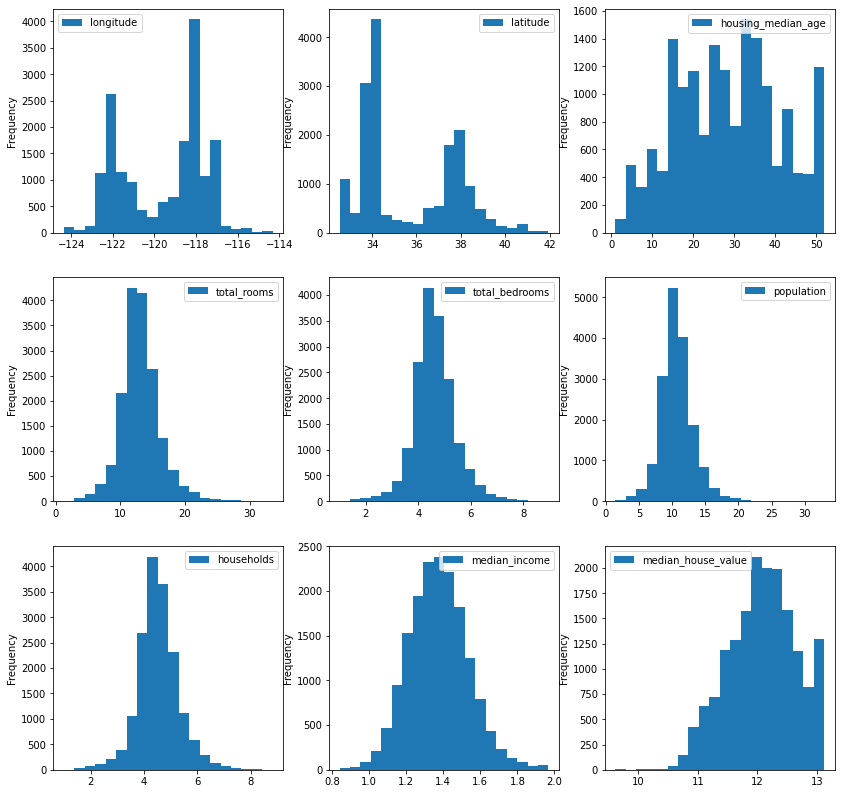

In [ ]:
datatrain_transformed = datatrain.copy()

# Combat biases
datatrain_transformed["households"] = np.power(datatrain_transformed["households"],
                                               1/4)
datatrain_transformed["total_rooms"] = np.power(datatrain_transformed["total_rooms"],
                                               1/3)
datatrain_transformed["total_bedrooms"] = np.power(datatrain_transformed["total_bedrooms"],
                                               1/4)
datatrain_transformed["population"] = np.power(datatrain_transformed["population"],
                                               1/3)
datatrain_transformed["median_income"] = np.power(datatrain_transformed["median_income"],
                                               1/4)

# Fix bias on the dependent variable, a log will suffice for this
datatrain_transformed["median_house_value"] = np.log(datatrain_transformed["median_house_value"])

plot_histogram(datatrain_transformed,3,3)

## f)
A partir del resumen descriptivo de los datos preprocesados en el inciso anterior y usando solamente las variables independientes, aplica una transformación para que cada variable quede centrada en el origen y todas en un mismo rango aproximadamente. ¿Por qué no incluimos en este caso a la variable dependiente de salida?

---

Porque no queremos alterar el valor final de la regresión, y la variable dependiente ya posee una forma acampanada, si escaláramos la variable dependiente y la centráramos en 0 ya no estaríamos prediciendo un valor correcto para nuestro modelo.

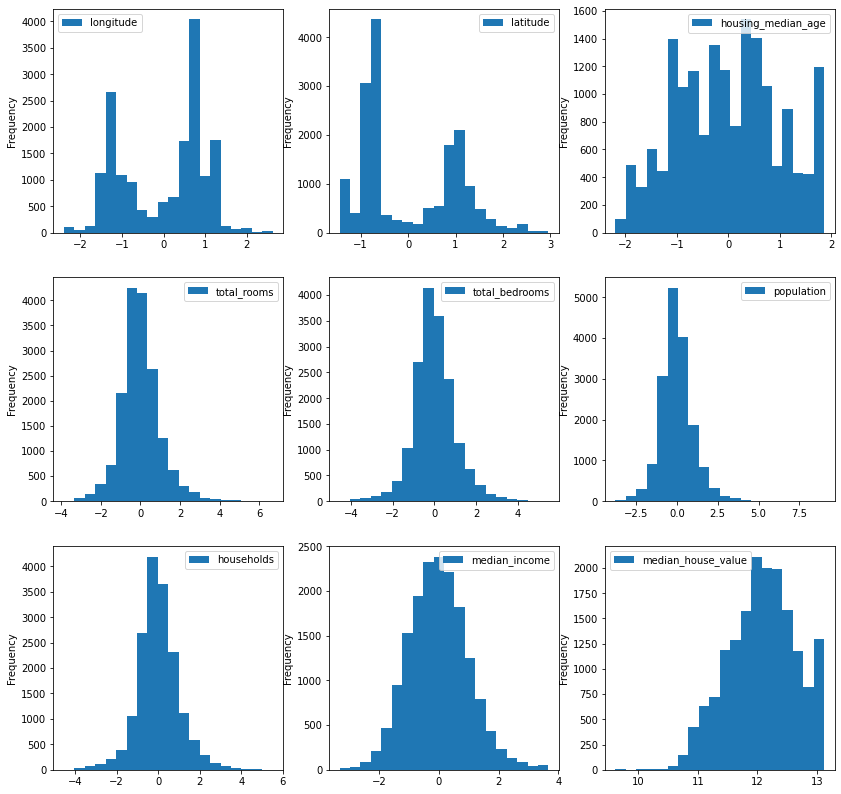

In [ ]:
datatrain_transformed_ctr = datatrain_transformed.copy()

# Scale between [0, 1]
def scale_range(column):
    return (column - np.min(column)) / (np.max(column) - np.min(column))

columns_to_scale = ["housing_median_age",
                    "total_rooms",
                    "total_bedrooms",
                    "population",
                    "households",
                    "median_income"]
datatrain_transformed_ctr[columns_to_scale] = scale_range(datatrain_transformed_ctr[columns_to_scale])

# Centering on 0
def center_std(column):
    return (column - np.mean(column)) / np.std(column)

columns_to_center = ["latitude",
                     "longitude",
                     "housing_median_age",
                     "total_rooms",
                     "total_bedrooms",
                     "population",
                     "households",
                     "median_income"]

datatrain_transformed_ctr[columns_to_center] = center_std(datatrain_transformed_ctr[columns_to_center])


plot_histogram(datatrain_transformed_ctr,3,3)

In [ ]:
datatrain_transformed_ctr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,17000.000000
mean,-1.839584e-13,-1.592791e-13,4.040043e-14,-3.486967e-14,-2.796461e-14,-2.950397e-14,3.753599e-14,2.892382e-14,12.085843
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,0.571653
min,-2.387848e+00,-1.443531e+00,-2.191968e+00,-3.859433e+00,-4.539986e+00,-3.754970e+00,-4.541379e+00,-3.311156e+00,9.615739
25%,-1.111108e+00,-7.931704e-01,-8.413218e-01,-5.736135e-01,-5.832974e-01,-5.911763e-01,-5.619618e-01,-6.797473e-01,11.690234
50%,5.346887e-01,-6.434471e-01,3.262582e-02,-8.160977e-02,-6.483647e-02,-7.053352e-02,-4.920360e-02,-2.059176e-02,12.102932
75%,7.790646e-01,9.801141e-01,6.682241e-01,5.047313e-01,5.398174e-01,5.196831e-01,5.454667e-01,6.328320e-01,12.487485
max,2.619365e+00,2.959268e+00,1.859971e+00,6.672812e+00,5.454168e+00,9.010166e+00,5.517974e+00,3.670151e+00,13.122365


## g)
Obtener los coeficientes de correlación de Pearson de cada par de variables. Con base a estos resultados simplifica las variables que consideres adecuado. Justifica tu razonamiento.

In [ ]:
datatrain_transformed_ctr.corr(method="pearson")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925208,-0.114250,0.038608,0.069293,0.118642,0.062809,-0.014396,-0.022109
latitude,-0.925208,1.000000,0.016454,-0.037047,-0.073870,-0.140074,-0.091352,-0.087083,-0.193543
housing_median_age,-0.114250,0.016454,1.000000,-0.360228,-0.304468,-0.288269,-0.276372,-0.132839,0.076881
total_rooms,0.038608,-0.037047,-0.360228,1.000000,0.935860,0.861176,0.923859,0.255750,0.188262
total_bedrooms,0.069293,-0.073870,-0.304468,0.935860,1.000000,0.895284,0.977283,0.005169,0.087332
population,0.118642,-0.140074,-0.288269,0.861176,0.895284,1.000000,0.925426,0.018999,0.017752
households,0.062809,-0.091352,-0.276372,0.923859,0.977283,0.925426,1.000000,0.037827,0.112776
median_income,-0.014396,-0.087083,-0.132839,0.255750,0.005169,0.018999,0.037827,1.000000,0.684645
median_house_value,-0.022109,-0.193543,0.076881,0.188262,0.087332,0.017752,0.112776,0.684645,1.000000


---

Se tomará un valor absoluto $Pearson >= 0.9$ como el umbral para determinar que las variables están altamente correlacionadas con excepción de la latitud y longitud, que si bien están altamente correlacionadas, describen diferente información. Entendiendo esto, se aprecian que las siguientes variables están altamente correlacionadas:

1. total_rooms
1. total_bedrooms
1. population
1. households

Esta correlación es muy grande, alrededor de 0.9 en todos los casos entre todas ellas. La variable que tiene más correlación con todas las otras es *households* así que es la que debemos eliminar.

Si bien existe una alta correlación entre *total_rooms* y *total_bedrooms*, podemos eliminar una de ellas. Después de experimentar un poco, podemos ver que el modelo se comporta mejor si se elimina *total_rooms*

Como dato adicional, la matriz de correlación indica que *median_income* tiene una significativa correlación con la variable dependiente *median_house_value*, esta variable debe estar en el dataset. Esto puede explicarse porque, al tener mayores ingresos, las personas podrán casas con mayor valor.

En resumen, estas son las variables que deben preservarse:

1. longitude
1. latitude
1. housing_median_age
1. total_beedrooms
1. population
1. median_income

In [ ]:
columns_to_remove = ["total_rooms",
                     "households"]
clean_datatrain = datatrain_transformed_ctr.drop(columns_to_remove, axis=1)

clean_datatrain.corr(method="pearson")


,longitude,latitude,housing_median_age,total_bedrooms,population,median_income,median_house_value
longitude,1.000000,-0.925208,-0.114250,0.069293,0.118642,-0.014396,-0.022109
latitude,-0.925208,1.000000,0.016454,-0.073870,-0.140074,-0.087083,-0.193543
housing_median_age,-0.114250,0.016454,1.000000,-0.304468,-0.288269,-0.132839,0.076881
total_bedrooms,0.069293,-0.073870,-0.304468,1.000000,0.895284,0.005169,0.087332
population,0.118642,-0.140074,-0.288269,0.895284,1.000000,0.018999,0.017752
median_income,-0.014396,-0.087083,-0.132839,0.005169,0.018999,1.000000,0.684645
median_house_value,-0.022109,-0.193543,0.076881,0.087332,0.017752,0.684645,1.000000


## h)
Usando los datos preprocesados hasta el inciso anterior, realiza una partición aleatoria en un conjunto de datos de entrenamiento del 80% y otro de validación del 20%. Reporta los coeficientes de regresión del modelo, la significancia de cada coeficiente, el promedio de la suma del cuadrado de los residuos MSSE y el coeficiente de correlación ajustado. Además, medir el desempeño de las predicciones del modelo con la métrica del coeficiente de Pearson y el coseno del ángulo. Escribe tus conclusiones comparándolo con el resultado del inciso (a).

In [ ]:
X_train_clean, y_train_clean = separate_variables_labels(clean_datatrain,
                                                         "median_house_value")

def print_model_metrics(y_real, y_predicted, X):
    
    # Metrics
    print("\n\n ********* METRICS ********* \n\n")
    print(f"MSE para dataset de validacion: {mse(y_real, y_predicted)}")
    print(f"Adj. R^2: {adj_r_squared(y_real, y_predicted, n_samples = X.shape[0], k_ind_var=X.shape[1])}")
    print(f"Pearson y_real vs y_predicted: {my_pearson(y_real, y_predicted)}")
    print(f"Cosine similarity y_real vs y_predicted: {my_cosine_similarity(y_real, y_predicted)}")


def evaluate_partition(X: pd.DataFrame,
                       y: np.array,
                       train_size: float):

    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      train_size=train_size,
                                                      random_state=42)
    print(f" ============ Train Partition Size: {train_size} ============\n\n")

    # Train the model
    model = train_regression_model(X_train, y_train)

    # Get predictions on the validation Set
    y_predicted_val_basic_model = predict(model, X_val)

    print_model_metrics(y_val, y_predicted_val_basic_model, X_val)

    return model

model_h = evaluate_partition(X_train_clean, y_train_clean, train_size=0.8)


 ============ Train Partition Size: 0.8 ============


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     4737.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:45:24   Log-Likelihood:                -3994.3
No. Observations:               13600   AIC:                             8003.
Df Residuals:                   13593   BIC:                             8055.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

---
### Conclusiones

Los resultados en general mejoraron bastante. Se usó una partición de train/val de 80/20%.

Los valores P para los coeficientes nos dicen que es lo mejor que el modelo puede hacer con los datos dados.

En el anterior modelo se tenía $R^2_{adj}=0.6185$, en comparación con el obtenido de $R^2_{adj}=0.6962$ hay un incremento bastante bueno.

El coseno entre los vectores reales y de predicción pasaron de 0.9549 a 0.9997 que representa una ganancia de más de 0.04, lo cual es muy bueno.

El coeficiente de Pearson entre las predicciones y los datos reales también se vió incrementado de 0.79 a 0.8349.

El MSE se vió drásticamente disminuído, lo cual está explicado en gran parte por el escalamiento de las variables y el suavizamiento de la variable dependiente con un logaritmo. La transformación de la variable dependiente puede revertirse para obtener un valor real para el problema dado.

Esto nos indica que hacer un EDA y ajuste de datos puede ser la gran diferencia entre tener un modelo mediocre y un modelo mucho mejor.

## i)
Prueba otras particiones de los conjuntos de entrenamiento y validación y en caso de obtener un mejor resultado en relación al inciso anterior, reporta aquí su resultado. Utiliza los valores de $R^2_{adj}$ y el coseno del ángulo para comparar los modelos. Para fines de este ejercicio, continuaremos con la partición de 80%/20% en las siguientes preguntas.


### Train/Val 90/10

In [ ]:
evaluate_partition(X_train_clean, y_train_clean, train_size=0.9)

 ============ Train Partition Size: 0.9 ============


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     5414.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:49:14   Log-Likelihood:                -4443.9
No. Observations:               15300   AIC:                             8902.
Df Residuals:                   15293   BIC:                             8955.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

### Train/Val 99/1

In [ ]:
evaluate_partition(X_train_clean, y_train_clean, train_size=0.99)

 ============ Train Partition Size: 0.99 ============


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     5975.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:49:57   Log-Likelihood:                -4865.8
No. Observations:               16830   AIC:                             9746.
Df Residuals:                   16823   BIC:                             9800.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

### Train/Val 60/40

In [ ]:
evaluate_partition(X_train_clean, y_train_clean, train_size=0.6)

 ============ Train Partition Size: 0.6 ============


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     3491.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:50:30   Log-Likelihood:                -3086.3
No. Observations:               10200   AIC:                             6187.
Df Residuals:                   10193   BIC:                             6237.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

---

### Conclusiones

No se encuentra un mejor modelo ni al incrementar el tamaño del set de entrenamiento ni al disminuir el tamaño del set de entrenamiento, lo que parece indicar que hemos encontrado lo mejor que podemos hacer con un modelo lineal.

## j)
Aplicar el modelo de máquinas de vectores de sporte (SVM) al problema. Deberás indicar el mejor modelo obtenido incluyendo al menos el valor del coeficiente asociado a las variables de holgura C, el modelo utilizado (lineal, o el de algún kernel no-lineal) y el valor del hiperparámetro gamma, en caso de haber usado un kernel nolineal. Reporta las métricas en relación a las predicciones del modelo mediante el coeficiente de correlación de Pearson y el coseno del ángulo.

### SVM Lineales

In [ ]:
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train_clean,
                                                                  y_train_clean,
                                                                  train_size=0.8,
                                                                  random_state=42)

#### Grid Search para C y un modelo lineal

In [ ]:
param_grid = {
    "kernel": ["linear"],
    "C": [0.01, 0.1, 1, 10, 100]
    }

svm_grid_search_linear = GridSearchCV(svm.SVR(),
                                      param_grid=param_grid,
                                      verbose=3,
                                      n_jobs=-1,
                                      cv=2)

svm_grid_search_linear.fit(X_train_svm, y_train_svm)

print("Los mejores parametros son %s con un score de %0.2f"
      % (svm_grid_search_linear.best_params_, svm_grid_search_linear.best_score_))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.0min finished


Los mejores parametros son {'C': 0.01, 'kernel': 'linear'} con un score de 0.67


In [ ]:
pd.DataFrame.from_dict(svm_grid_search_linear.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,2.251604,0.027895,0.526392,0.004403,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.674639,0.671287,0.672963,0.001676,1
1,2.595148,0.018202,0.522783,0.007692,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.675402,0.670401,0.672902,0.002500,2
2,8.522999,0.156124,0.512253,0.002764,1,linear,"{'C': 1, 'kernel': 'linear'}",0.675352,0.670253,0.672803,0.002550,3
3,52.065813,0.957005,0.510550,0.002028,10,linear,"{'C': 10, 'kernel': 'linear'}",0.675301,0.670201,0.672751,0.002550,4
4,403.462439,7.554402,0.397557,0.125686,100,linear,"{'C': 100, 'kernel': 'linear'}",0.675336,0.670161,0.672749,0.002588,5


In [ ]:
model_j_svm_linear = svm_grid_search_linear.best_estimator_

y_predicted_svm_linear = model_j_svm_linear.predict(X_val_svm)

print_model_metrics(y_val_svm, y_predicted_svm_linear, X_val_svm)



 ********* METRICS ********* 


MSE para dataset de validacion: 0.10040772310891993
Adj. R^2: 0.6964011704499411
Pearson y_real vs y_predicted: 0.8353184378809089
Cosine similarity y_real vs y_predicted: 0.9996583156206458


### SVM No-Lineales

#### Grid search para C, gamma y modelos no lineales

In [ ]:
param_grid = {
    "kernel": [
               #"poly", # Se omitirá el kernel poly debido a que es muy tardado en entrenar
               "rbf",
               "sigmoid"
               ],
    "C": [
          0.01,
          0.1,
          1
          ],
    "gamma": [
              0.001,
              0.01,
              0.1,
              1,
              5
              ]
    }

svm_grid_search_non_linear = GridSearchCV(svm.SVR(),
                                      param_grid=param_grid,
                                      verbose=10,
                                      n_jobs=-1,
                                      cv=2)

svm_grid_search_non_linear.fit(X_train_svm, y_train_svm)

print("Los mejores parametros son %s con un score de %0.2f"
      % (svm_grid_search_non_linear.best_params_, svm_grid_search_non_linear.best_score_))

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


Los mejores parametros son {'C': 1, 'gamma': 1, 'kernel': 'rbf'} con un score de 0.76


In [ ]:
pd.DataFrame.from_dict(svm_grid_search_non_linear.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,3.894874,0.023924,1.925214,0.009218,0.01,0.001,rbf,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",1.617938e-01,1.576330e-01,1.597134e-01,0.002080,20
1,3.683904,0.013232,1.971551,0.007933,0.01,0.001,sigmoid,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",8.925679e-02,8.554491e-02,8.740085e-02,0.001856,22
2,3.331378,0.024111,1.819996,0.025077,0.01,0.01,rbf,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",5.248394e-01,5.288552e-01,5.268473e-01,0.002008,14
3,3.461625,0.041485,1.897844,0.010977,0.01,0.01,sigmoid,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",4.475583e-01,4.468483e-01,4.472033e-01,0.000355,17
4,3.146513,0.018904,1.739240,0.001284,0.01,0.1,rbf,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",6.420666e-01,6.495063e-01,6.457864e-01,0.003720,9
5,4.160898,0.001493,2.347626,0.025956,0.01,0.1,sigmoid,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'sigmoid'}",3.100572e-01,2.352831e-01,2.726702e-01,0.037387,19
6,3.079777,0.004099,1.753944,0.001583,0.01,1,rbf,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",4.824133e-01,4.781507e-01,4.802820e-01,0.002131,15
7,5.864930,0.019667,3.529963,0.005761,0.01,1,sigmoid,"{'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}",-1.530145e+02,-1.465347e+02,-1.497746e+02,3.239898,24
8,3.902340,0.003527,1.874947,0.011319,0.01,5,rbf,"{'C': 0.01, 'gamma': 5, 'kernel': 'rbf'}",1.040612e-01,9.825989e-02,1.011605e-01,0.002901,21
9,5.482787,0.103782,3.309882,0.008165,0.01,5,sigmoid,"{'C': 0.01, 'gamma': 5, 'kernel': 'sigmoid'}",-2.417236e+02,-2.339416e+02,-2.378326e+02,3.891035,25


In [ ]:
model_j_svm_non_linear = svm_grid_search_non_linear.best_estimator_

y_predicted_svm_non_linear = model_j_svm_non_linear.predict(X_val_svm)

print_model_metrics(y_val_svm, y_predicted_svm_non_linear, X_val_svm)



 ********* METRICS ********* 


MSE para dataset de validacion: 0.06951944580563398
Adj. R^2: 0.7897968231521004
Pearson y_real vs y_predicted: 0.8889162471612487
Cosine similarity y_real vs y_predicted: 0.9997629223286151


## k)
En la siguiente liga: (https://doi.org/10.1016/S0167-7152(96)00140-X) se encuentra el artículo original de los autores que generaron la base de datos California_Housing. Recurre a la base de datos del Tecnológico de Monterrey (https://biblioteca.tec.mx/inicio) para bajar dicho artículo (lo encuentras en la base de datos de las revistas de ScienceDirect). Aunque el conjunto original de datos utilizado por los autores en dicho artículo es ligeramente diferente a los de Kaggle que estamos utilizando, obtener el modelo no-lineal propuesto por los autores en la ecuación (8) de la página 295, usando el conjunto de entrenamiento y realiza la validación. Reporta las métricas en relación a las predicciones del modelo mediante el coeficiente de correlación de Pearson y el coseno del ángulo.

---
El modelo está respresentado por:

$ln(medianValue) = Intercept + \beta_2 medianIncome +
\beta_3 medianIncome^2 +
\beta_4 medianIncome^3 +
\beta_5 ln(medianAge) +
\beta_6 ln(totalRooms/population) +
\beta_7 ln(bedrooms/population) +
\beta_8 ln(population/households) +
\beta_9 ln(households)$

In [ ]:
def dataset_2_paper_dataset(data: pd.DataFrame):
    paper_data = pd.DataFrame()

    paper_data["b2"] = data["median_income"]
    paper_data["b3"] = np.square(data["median_income"])
    paper_data["b4"] = np.power(data["median_income"], 3)
    paper_data["b5"] = np.log(data["housing_median_age"])
    paper_data["b6"] = np.log(data["total_rooms"] / data["population"])
    paper_data["b7"] = np.log(data["total_bedrooms"] / data["population"])
    paper_data["b8"] = np.log(data["population"] / data["households"])
    paper_data["b9"] = np.log(data["households"])
    paper_data["medianValue"] = np.log(data["median_house_value"])

    return paper_data

paper_datatrain = dataset_2_paper_dataset(datatrain)

In [ ]:
paper_model = evaluate_partition(paper_datatrain.drop("medianValue", axis=1),
                                 paper_datatrain["medianValue"],
                                 train_size=0.8)

 ============ Train Partition Size: 0.8 ============


                            OLS Regression Results                            
Dep. Variable:            medianValue   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     2639.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:52:36   Log-Likelihood:                -5293.0
No. Observations:               13600   AIC:                         1.060e+04
Df Residuals:                   13591   BIC:                         1.067e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

---
### Conclusiones

Los coeficientes son muy similares a los del modelo del paper, incluyendo la métrica de $R^2_{adj}$, con una partición de train/val de 80/20 se obtiene un ángulo coseno de 0.999 que es muy bueno, sin embargo el modelo obtenido en el inciso h es ligeramente mejor en todas sus métricas.

## l)
Incluye un nuevo factor (variable/columna) llamada "zona" para dividir el conjunto de casas en 3 regiones.

Para fines de este ejercicio las llamaremos A, B y C, correspondientes a "latitude<34.7", "(latitude>=34.7) & (longitude<-120)" y "(latitude>=34.7) & (longitude>=-120)", respectivamente.

Incluye dicho factor, verifica la correlación de Pearson con respecto a la latitude y longitude y obtén el modelo de RLM, reportando el desempeño del modelo en relación a las predicciones del modelo mediante el coeficiente de correlación de Pearson y el coseno del ángulo.

In [ ]:
def geographical_2_zones(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()
    
    df.loc[df["latitude"] < 34.7, "zona"] = 0
    df.loc[(df["latitude"] >= 34.7) & (df["longitude"] < -120), "zona"] = 1
    df.loc[(df["latitude"] >= 34.7) & (df["longitude"] >= -120), "zona"] = 2

    # Move column to the beginning of the DataFrame
    zona = df["zona"]
    df.drop("zona", axis=1, inplace = True)
    df.insert(0, "zona", zona.astype(int))

    return df

# We cleaned the dataset and centered latitude and longitude we need to restore
#  the original columns for a proper classification
zone_datatrain = clean_datatrain.copy()
zone_datatrain["latitude"] = datatrain["latitude"]
zone_datatrain["longitude"] = datatrain["longitude"]

# Replace the latitude and longitude in the clean_datatrain
zone_datatrain = geographical_2_zones(zone_datatrain)

zone_datatrain[["longitude", "latitude", "zona"]].corr(method="pearson")

,longitude,latitude,zona
longitude,1.000000,-0.925208,-0.698336
latitude,-0.925208,1.000000,0.770696
zona,-0.698336,0.770696,1.000000


In [ ]:
# Convertimos a zonas str previo a su one-hot encoding para su visualización
zone_datatrain.loc[zone_datatrain["zona"] == 0, "zona"] = "A"
zone_datatrain.loc[zone_datatrain["zona"] == 1, "zona"] = "B"
zone_datatrain.loc[zone_datatrain["zona"] == 2, "zona"] = "C"
zone_datatrain["zona"].value_counts()

A    9196
B    6688
C    1116
Name: zona, dtype: int64

### Convertimos la zona a One-Hot Encoding

Se optará por tener una columna por cada uno de los valores de zona, que se guardan en una columna zona_{valor}, es decir, hacer un one-hot encoding de la variable clasificadora zona. Estas nuevas columnas reemplazaran a las columnas latitude, longitude y zona.

In [ ]:
### TO ONE-HOT ENCODING
zone_one_hot_encoding = pd.get_dummies(zone_datatrain["zona"], prefix="zona")

zone_datatrain_one_hot = pd.concat([zone_one_hot_encoding, zone_datatrain], axis=1)
zone_datatrain_one_hot.head()

,zona_A,zona_B,zona_C,zona,longitude,latitude,housing_median_age,total_bedrooms,population,median_income,median_house_value
0,1,0,0,A,-114.31,34.19,-1.079671,1.718823,-0.264575,-1.671988,11.110954
1,1,0,0,A,-114.47,34.40,-0.761872,2.494966,-0.117385,-1.325154,11.291031
2,1,0,0,A,-114.56,33.69,-0.920772,-1.235456,-1.529126,-1.498418,11.358608
3,1,0,0,A,-114.57,33.64,-1.159121,-0.416027,-1.089438,-0.240514,11.203679
4,1,0,0,A,-114.57,33.57,-0.682422,-0.460473,-0.874632,-1.223565,11.089805


In [ ]:
zone_datatrain_one_hot.drop(["latitude", "longitude", "zona"], axis=1, inplace = True)
zone_datatrain_one_hot.describe()

,zona_A,zona_B,zona_C,housing_median_age,total_bedrooms,population,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,1.700000e+04,1.700000e+04,1.700000e+04,1.700000e+04,17000.000000
mean,0.540941,0.393412,0.065647,4.040043e-14,-2.796461e-14,-2.950397e-14,2.892382e-14,12.085843
std,0.498336,0.488521,0.247671,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,0.571653
min,0.000000,0.000000,0.000000,-2.191968e+00,-4.539986e+00,-3.754970e+00,-3.311156e+00,9.615739
25%,0.000000,0.000000,0.000000,-8.413218e-01,-5.832974e-01,-5.911763e-01,-6.797473e-01,11.690234
50%,1.000000,0.000000,0.000000,3.262582e-02,-6.483647e-02,-7.053352e-02,-2.059176e-02,12.102932
75%,1.000000,1.000000,0.000000,6.682241e-01,5.398174e-01,5.196831e-01,6.328320e-01,12.487485
max,1.000000,1.000000,1.000000,1.859971e+00,5.454168e+00,9.010166e+00,3.670151e+00,13.122365


In [ ]:
zone_datatrain_one_hot.corr(method="pearson")

,zona_A,zona_B,zona_C,housing_median_age,total_bedrooms,population,median_income,median_house_value
zona_A,1.000000,-0.874214,-0.287735,0.004645,0.075511,0.130023,0.079207,0.208167
zona_B,-0.874214,1.000000,-0.213466,0.037612,-0.059378,-0.115726,-0.001222,-0.024538
zona_C,-0.287735,-0.213466,1.000000,-0.083534,-0.034813,-0.033352,-0.156960,-0.370449
housing_median_age,0.004645,0.037612,-0.083534,1.000000,-0.304468,-0.288269,-0.132839,0.076881
total_bedrooms,0.075511,-0.059378,-0.034813,-0.304468,1.000000,0.895284,0.005169,0.087332
population,0.130023,-0.115726,-0.033352,-0.288269,0.895284,1.000000,0.018999,0.017752
median_income,0.079207,-0.001222,-0.156960,-0.132839,0.005169,0.018999,1.000000,0.684645
median_house_value,0.208167,-0.024538,-0.370449,0.076881,0.087332,0.017752,0.684645,1.000000


In [ ]:
model_l = evaluate_partition(zone_datatrain_one_hot.drop("median_house_value", axis=1),
                             zone_datatrain_one_hot["median_house_value"],
                             train_size=0.8)

 ============ Train Partition Size: 0.8 ============


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     3426.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:04:50   Log-Likelihood:                -5402.9
No. Observations:               13600   AIC:                         1.082e+04
Df Residuals:                   13593   BIC:                         1.087e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

### Conclusiones

Se obtienen resultados ligeramente mejores al modelo del paper, pero ligeramente peores que el modelo con datos limpios y centrados.

# 3.
Con respecto al mejor modelo obtenido en los incisos anteriores, obtener el desempeño final de tu modelo mediante los datos de prueba del archivo `california_housing_test.csv`. Reporta el desempeño del modelo en relación a las predicciones del modelo mediante el coeficiente de correlación de Pearson y el coseno del ángulo. 

## Mejor modelo lineal

In [ ]:
best_model = model_h

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Combat biases
    df["households"] = np.power(df["households"],
                                                1/4)
    df["total_rooms"] = np.power(df["total_rooms"],
                                                1/3)
    df["total_bedrooms"] = np.power(df["total_bedrooms"],
                                                1/4)
    df["population"] = np.power(df["population"],
                                                1/3)
    df["median_income"] = np.power(df["median_income"],
                                                1/4)

    # Fix bias on the dependent variable
    df["median_house_value"] = np.log(df["median_house_value"])
    
    # Scale between [0, 1]
    columns_to_scale = ["housing_median_age",
                    "total_rooms",
                    "total_bedrooms",
                    "population",
                    "households",
                    "median_income"]
    df[columns_to_scale] = scale_range(df[columns_to_scale])

    # Center on 0
    columns_to_center = ["latitude",
                     "longitude",
                     "housing_median_age",
                     "total_rooms",
                     "total_bedrooms",
                     "population",
                     "households",
                     "median_income"]

    df[columns_to_center] = center_std(df[columns_to_center])

    # Remove highly correlated columns
    columns_to_remove = ["total_rooms",
                         "households"]
    df.drop(columns_to_remove,
            axis=1,
            inplace=True)
    
    return df

clean_datatest = clean_data(datatest)

# Separate features and dependent variable
X_best, y_best = separate_variables_labels(clean_datatest, "median_house_value")

In [ ]:
# Get predictions on the Test Set

y_predicted_best = predict(best_model, X_best)

print_model_metrics(y_best, y_predicted_best, X_best)



 ********* METRICS ********* 


MSE para dataset de validacion: 0.11218321266224943
Adj. R^2: 0.6376126749010809
Pearson y_real vs y_predicted: 0.8002815042535748
Cosine similarity y_real vs y_predicted: 0.9996167204859572


# Mejor modelo encontrado: SVM no lineal RBF

In [ ]:
y_predicted_best = model_j_svm_non_linear.predict(X_best)

print_model_metrics(y_best, y_predicted_best, X_best)



 ********* METRICS ********* 


MSE para dataset de validacion: 0.07461571189320224
Adj. R^2: 0.758967606635246
Pearson y_real vs y_predicted: 0.8718070511958718
Cosine similarity y_real vs y_predicted: 0.9997451266896141


### Conclusiones

Comparado con el modelo base sin hacer ningún procesamiento de datos, los resultados obtenidos son muy buenos luego de tratar los datos con un análisis estadístico.

Sin embargo, hay un límite de lo que se puede hacer con modelos lineales en algunos problemas, como este. Si bien se consiguió un modelo lineal que incluso superó ligeramente al modelo del paper, se obtuvo un mejor modelo con un SVM No Lineal que usa un kernel Radial Basis Function.

Las ganancias con un modelo no lineal son palpables en el coseno del ángulo entre las predicciones y los valores reales, pero son determinantes en el valor de $R^2_{adj} = 0.7590$ y en la correlación Pearson de 0.87181, lo que indica que la SVM No Lineal generaliza aún mejor a nuestro dataset de pruebas.

Independientemente de qué tipo de modelo se usará, siempre se debe saber con qué tipo de problema nos estamos enfrentando, un análisis estadístico de datos es crucial antes de tomar la decisión y más aún, se requerirá explorar varias opciones antes de hacerlo.